# Tox 24 challenge - see how deepFPlearn performs

We are doing the following steps
- load challenge data: training and test datasets
- remove duplicated SMILES with different target values
- scale the target value to the range [0, 1]
- use the whole set of SMILES (test and train substances), generate 2048 bit binary molecular fingerprints, train a specific autoencoder for compressing 2048 bit binary molecular fingerprints into 256 bit vectors with less zeros
- use the trained specific autoencoder to encode the 2048 bit fingerprints of the training substances
- train a regression model with this data 
- use the trained autoencoder to encode the test substances, use the regression model to predict the scaled target values
- reverse the scaling of the target values
- submit the predictions

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import wandb
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
import os
import fnmatch
from IPython.display import Image, display
from keras.models import load_model

from dfpl import options, fingerprint as fp, utils, autoencoder as ac, single_label_model as sl, predictions


2024-08-08 15:42:21.661254: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/hertelj/build/local/miniforge3/envs/dfpl/lib/python3.10/site-packages/tensorflow/python/keras/engine/training_arrays_v1.py:37: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.22.4)
  from scipy.sparse import issparse  # pylint: disable=g-import-not-at-top


In [2]:
base_out_dir = 'data/output/fnn_compressed/'

In [3]:
pd.concat([pd.read_csv('data/tox24_challenge_train.csv'),
           pd.read_csv('data/tox24_challenge_test.csv')],
          ignore_index=True).to_csv('data/tox24_challenge_smiles_all.csv', index=False)

## Train the autoencoder

For this load train and test datasets first to get the full set of molecular structures. Store all structures again in a .csv file.

Adjust all options for training the autoencoder

In [4]:
opts = options.Options(
    inputFile='data/tox24_challenge_smiles_all.csv',
    outputDir=f'{base_out_dir}',
    ecModelDir=f'{base_out_dir}/AE_encoder/',
    ecWeightsFile='',
    type='smiles',
    fpType='topological',
    fpSize=2048,
    encFPSize=256,
    verbose=2,
    trainAC=True,
    aeActivationFunction='tanh',
    aeEpochs=3000,
    aeBatchSize=52,
    aeLearningRate=0.004123771070856377,
    aeLearningRateDecay=0.05465859583974732,
    trainFNN=False,
    wabTracking=True,
)


Allow tracking the training in Weights & Biases.

This requires a Weights & Biases account and at least the free plan. Feel free to comment this code cell.

In [5]:
if opts.wabTracking:
    wandb.init(project=f"tox_24",
               entity="dfpl_regression",
               config=vars(opts))

wandb: Currently logged in as: mai00fti (dfpl_regression). Use `wandb login --relogin` to force relogin


Load the training data and generate fingerprints.

In [6]:
df = fp.importDataFile(opts.inputFile, import_function=fp.importCSV, fp_size=opts.fpSize)

Train the autoencoder

In [7]:
opts.trainAC=False

In [8]:
utils.createDirectory(opts.outputDir)

# opts.trainAC=False
if opts.trainAC:
    # train an autoencoder on the full feature matrix
    encoder = ac.train_full_ac(df, opts)

Update the options for training the regression model with compressed features.

In [9]:
opts = options.Options(
    inputFile='data/tox24_challenge_train.csv',
    outputDir=f'{base_out_dir}',
    ecModelDir=f'{base_out_dir}/AE_encoder/',
    ecWeightsFile='',
    type='smiles',
    fpType='topological',
    fpSize=2048,
    encFPSize=256,
    verbose=2,
    trainFNN=True,
    compressFeatures=True,
    kFolds=5,
    testSize=0.2,
    optimizer="SGD",
    lossFunction="mse",
    epochs=5000,
    batchSize=56,
    activationFunction="tanh",
    dropout=0.15657883016344468,
    learningRate=0.017935022040821466,
    l2reg=0.009308121424156192,
    fnnType="REG",
    enableMultiLabel=False,
    wabTarget="activity",
)


In [10]:
df = fp.importDataFile(opts.inputFile, import_function=fp.importCSV, fp_size=opts.fpSize)

In [11]:
if opts.compressFeatures:
    # load trained model for autoencoder
    encoder = keras.models.load_model(opts.ecModelDir)

    # compress the fingerprints using the autoencoder
    df = ac.compress_fingerprints(df, encoder)

2024-08-08 15:42:31.575386: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-08 15:42:31.576023: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-08 15:42:31.576102: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-08 15:42:31.576422: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the

32/32 [==============================] - 0s 903us/step


2024-08-08 15:42:31.982967: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Scale the target values to [0,1]

In [12]:
df.columns

Index(['SMILES', 'activity', 'fp', 'fpcompressed'], dtype='object')

In [13]:
unscaled_target = df['activity'].to_numpy().reshape(-1, 1)

scaler = MinMaxScaler()
scaler.fit(unscaled_target)
scaled_target = scaler.transform(unscaled_target)
df = df.drop('activity', axis=1)
df = pd.concat([df, pd.DataFrame(scaled_target, columns=['activity'])], axis=1)

Now train the regression model

In [14]:
opts.inputFile

'data/tox24_challenge_train.csv'

In [15]:
if opts.trainFNN:
    sl.train_single_label_models(df=df, opts=opts);

/home/hertelj/build/local/miniforge3/envs/dfpl/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


/home/hertelj/build/local/miniforge3/envs/dfpl/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/5000
15/15 - 0s - loss: 4.6716 - rmse: 0.7582 - mse: 0.5749 - mae: 0.5786 - val_loss: 4.0641 - val_rmse: 0.3140 - val_mse: 0.0986 - val_mae: 0.2658 - 301ms/epoch - 20ms/step
Epoch 2/5000
15/15 - 0s - loss: 3.8907 - rmse: 0.2704 - mse: 0.0731 - mae: 0.2081 - val_loss: 3.6454 - val_rmse: 0.1349 - val_mse: 0.0182 - val_mae: 0.1107 - 24ms/epoch - 2ms/step
Epoch 3/5000
15/15 - 0s - loss: 3.4888 - rmse: 0.1362 - mse: 0.0185 - mae: 0.1063 - val_loss: 3.2961 - val_rmse: 0.1234 - val_mse: 0.0152 - val_mae: 0.1132 - 30ms/epoch - 2ms/step
Epoch 4/5000
15/15 - 0s - loss: 3.1421 - rmse: 0.0885 - mse: 0.0078 - mae: 0.0655 - val_loss: 2.9614 - val_rmse: 0.0398 - val_mse: 0.0016 - val_mae: 0.0288 - 30ms/epoch - 2ms/step
Epoch 5/5000
15/15 - 0s - loss: 2.8308 - rmse: 0.0641 - mse: 0.0041 - mae: 0.0418 - val_loss: 2.6699 - val_rmse: 0.0327 - val_mse: 0.0011 - val_mae: 0.0244 - 30ms/epoch - 2ms/step
Epoch 6/5000
15/15 - 0s - loss: 2.5517 - rmse: 0.0554 - mse: 0.0031 - mae: 0.0330 - val_loss: 2.40

INFO:tensorflow:Assets written to: data/output/fnn_compressed/activity-1_saved_model/assets


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mae,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
rmse,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mae,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_rmse,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,121
best_val_loss,2e-05


/home/hertelj/build/local/miniforge3/envs/dfpl/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/5000
15/15 - 0s - loss: 4.4966 - rmse: 0.6188 - mse: 0.3830 - mae: 0.4648 - val_loss: 4.0342 - val_rmse: 0.2430 - val_mse: 0.0591 - val_mae: 0.1982 - 422ms/epoch - 28ms/step
Epoch 2/5000
15/15 - 0s - loss: 3.8641 - rmse: 0.2013 - mse: 0.0405 - mae: 0.1595 - val_loss: 3.6475 - val_rmse: 0.1319 - val_mse: 0.0174 - val_mae: 0.0946 - 36ms/epoch - 2ms/step
Epoch 3/5000
15/15 - 0s - loss: 3.4797 - rmse: 0.0870 - mse: 0.0076 - mae: 0.0670 - val_loss: 3.2889 - val_rmse: 0.0826 - val_mse: 0.0068 - val_mae: 0.0371 - 40ms/epoch - 3ms/step
Epoch 4/5000
15/15 - 0s - loss: 3.1370 - rmse: 0.0405 - mse: 0.0016 - mae: 0.0325 - val_loss: 2.9667 - val_rmse: 0.0760 - val_mse: 0.0058 - val_mae: 0.0244 - 41ms/epoch - 3ms/step
Epoch 5/5000
15/15 - 0s - loss: 2.8283 - rmse: 0.0221 - mse: 4.8683e-04 - mae: 0.0174 - val_loss: 2.6752 - val_rmse: 0.0728 - val_mse: 0.0053 - val_mae: 0.0152 - 42ms/epoch - 3ms/step
Epoch 6/5000
15/15 - 0s - loss: 2.5499 - rmse: 0.0144 - mse: 2.0700e-04 - mae: 0.0113 - val_lo

INFO:tensorflow:Assets written to: data/output/fnn_compressed/activity-2_saved_model/assets


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mae,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
rmse,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mae,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_rmse,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,135
best_val_loss,0.00493


/home/hertelj/build/local/miniforge3/envs/dfpl/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/5000
15/15 - 1s - loss: 4.4894 - rmse: 0.6278 - mse: 0.3942 - mae: 0.4883 - val_loss: 4.0264 - val_rmse: 0.2640 - val_mse: 0.0697 - val_mae: 0.2116 - 671ms/epoch - 45ms/step
Epoch 2/5000
15/15 - 0s - loss: 3.8701 - rmse: 0.2548 - mse: 0.0649 - mae: 0.2072 - val_loss: 3.6258 - val_rmse: 0.1149 - val_mse: 0.0132 - val_mae: 0.0967 - 52ms/epoch - 3ms/step
Epoch 3/5000
15/15 - 0s - loss: 3.4728 - rmse: 0.1330 - mse: 0.0177 - mae: 0.1047 - val_loss: 3.2686 - val_rmse: 0.0510 - val_mse: 0.0026 - val_mae: 0.0410 - 33ms/epoch - 2ms/step
Epoch 4/5000
15/15 - 0s - loss: 3.1240 - rmse: 0.0651 - mse: 0.0042 - mae: 0.0448 - val_loss: 2.9475 - val_rmse: 0.0354 - val_mse: 0.0013 - val_mae: 0.0283 - 32ms/epoch - 2ms/step
Epoch 5/5000
15/15 - 0s - loss: 2.8160 - rmse: 0.0491 - mse: 0.0024 - mae: 0.0297 - val_loss: 2.6570 - val_rmse: 0.0214 - val_mse: 4.5645e-04 - val_mae: 0.0175 - 32ms/epoch - 2ms/step
Epoch 6/5000
15/15 - 0s - loss: 2.5388 - rmse: 0.0447 - mse: 0.0020 - mae: 0.0233 - val_loss: 

INFO:tensorflow:Assets written to: data/output/fnn_compressed/activity-3_saved_model/assets


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mae,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
rmse,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mae,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_rmse,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,132
best_val_loss,0.0


/home/hertelj/build/local/miniforge3/envs/dfpl/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/5000
15/15 - 0s - loss: 4.4414 - rmse: 0.5960 - mse: 0.3553 - mae: 0.4650 - val_loss: 4.0380 - val_rmse: 0.3026 - val_mse: 0.0916 - val_mae: 0.2450 - 418ms/epoch - 28ms/step
Epoch 2/5000
15/15 - 0s - loss: 3.8428 - rmse: 0.2191 - mse: 0.0480 - mae: 0.1681 - val_loss: 3.6094 - val_rmse: 0.0855 - val_mse: 0.0073 - val_mae: 0.0663 - 40ms/epoch - 3ms/step
Epoch 3/5000
15/15 - 0s - loss: 3.4539 - rmse: 0.0946 - mse: 0.0090 - mae: 0.0701 - val_loss: 3.2596 - val_rmse: 0.0568 - val_mse: 0.0032 - val_mae: 0.0448 - 40ms/epoch - 3ms/step
Epoch 4/5000
15/15 - 0s - loss: 3.1142 - rmse: 0.0611 - mse: 0.0037 - mae: 0.0401 - val_loss: 2.9385 - val_rmse: 0.0337 - val_mse: 0.0011 - val_mae: 0.0264 - 39ms/epoch - 3ms/step
Epoch 5/5000
15/15 - 0s - loss: 2.8071 - rmse: 0.0451 - mse: 0.0020 - mae: 0.0243 - val_loss: 2.6490 - val_rmse: 0.0204 - val_mse: 4.1809e-04 - val_mae: 0.0159 - 31ms/epoch - 2ms/step
Epoch 6/5000
15/15 - 0s - loss: 2.5309 - rmse: 0.0420 - mse: 0.0018 - mae: 0.0181 - val_loss: 

INFO:tensorflow:Assets written to: data/output/fnn_compressed/activity-4_saved_model/assets


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mae,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
rmse,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mae,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_rmse,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,138
best_val_loss,0.0


/home/hertelj/build/local/miniforge3/envs/dfpl/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/5000
15/15 - 0s - loss: 4.8909 - rmse: 0.8787 - mse: 0.7721 - mae: 0.6715 - val_loss: 4.1345 - val_rmse: 0.3652 - val_mse: 0.1334 - val_mae: 0.3000 - 242ms/epoch - 16ms/step
Epoch 2/5000
15/15 - 0s - loss: 3.9343 - rmse: 0.2752 - mse: 0.0757 - mae: 0.2211 - val_loss: 3.6893 - val_rmse: 0.1342 - val_mse: 0.0180 - val_mae: 0.1095 - 33ms/epoch - 2ms/step
Epoch 3/5000
15/15 - 0s - loss: 3.5305 - rmse: 0.1295 - mse: 0.0168 - mae: 0.1005 - val_loss: 3.3263 - val_rmse: 0.0546 - val_mse: 0.0030 - val_mae: 0.0435 - 36ms/epoch - 2ms/step
Epoch 4/5000
15/15 - 0s - loss: 3.1794 - rmse: 0.0665 - mse: 0.0044 - mae: 0.0463 - val_loss: 2.9996 - val_rmse: 0.0287 - val_mse: 8.2277e-04 - val_mae: 0.0231 - 39ms/epoch - 3ms/step
Epoch 5/5000
15/15 - 0s - loss: 2.8665 - rmse: 0.0508 - mse: 0.0026 - mae: 0.0306 - val_loss: 2.7045 - val_rmse: 0.0163 - val_mse: 2.6480e-04 - val_mae: 0.0130 - 46ms/epoch - 3ms/step
Epoch 6/5000
15/15 - 0s - loss: 2.5839 - rmse: 0.0399 - mse: 0.0016 - mae: 0.0186 - val_lo

INFO:tensorflow:Assets written to: data/output/fnn_compressed/activity-5_saved_model/assets


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mae,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
rmse,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mae,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_rmse,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,130
best_val_loss,1e-05


Find best fold

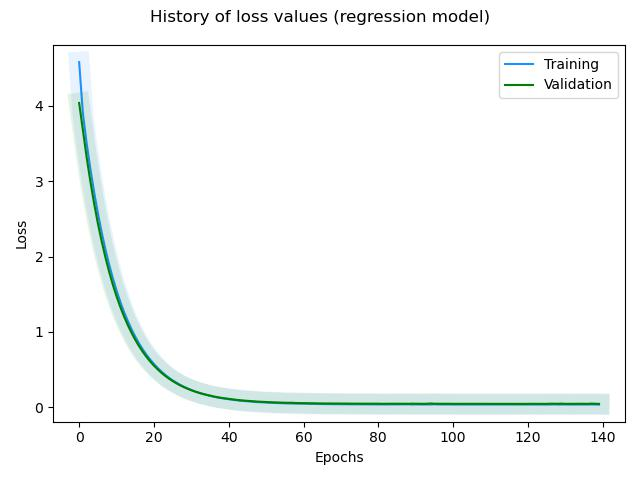

2

In [16]:
def find_files(directory, pattern):
    for root, dirs, files in os.walk(directory):
        for basename in files:
            if fnmatch.fnmatch(basename, pattern):
                filename = os.path.join(root, basename)
                yield filename


best_fold = 0
for filename in find_files(base_out_dir, '*.best.model.weights*'):
    filename_split = filename.split('.')
    best_fold = int(filename_split[0][-1])
    img_file = filename_split[0] + '.history.jpg'
    img = Image(filename=img_file)
    display(img)
best_fold

In [17]:
model_evaluation = pd.read_csv(
    filepath_or_buffer=f'{base_out_dir}/single_label_model.evaluation.csv')
model_evaluation[model_evaluation['fold'] == best_fold]

,Unnamed: 0,metric,value,fold,target
6,6,MSE,0.038129,2,activity
7,7,MAE,0.162599,2,activity
8,8,MdAE,0.155774,2,activity
9,9,ACPER,0.088670,2,activity
10,10,MAPE,inf,2,activity
11,11,RMSE,0.195267,2,activity


## Predict test dataset

In [18]:
opts = options.Options(
    inputFile='data/tox24_challenge_test.csv',
    outputDir=f'{base_out_dir}',
    outputFile=f'{base_out_dir}test.predictions.csv',
    ecModelDir=f'{base_out_dir}/AE_encoder/',
    fnnModelDir=f'{base_out_dir}/activity_saved_model',
    compressFeatures=True,
)

In [19]:
df = fp.importDataFile(opts.inputFile, import_function=fp.importSmilesCSV, fp_size=opts.fpSize)


In [20]:
if opts.compressFeatures:
    # load trained model for autoencoder
    encoder = keras.models.load_model(opts.ecModelDir)

    # compress the fingerprints using the autoencoder
    df = ac.compress_fingerprints(df, encoder)

16/16 [==============================] - 0s 921us/step


In [21]:
# predict
df2 = predictions.predict_values(df=df, opts=opts)

16/16 [==============================] - 0s 955us/step


In [23]:
df2.columns

Index(['SMILES', 'fp', 'fpcompressed', 'predicted'], dtype='object')

Reverse the scaling of the predicted values

In [37]:
activity_predicted = df2['predicted']

activity_predicted_rescaled = scaler.inverse_transform(activity_predicted.to_numpy().reshape(-1, 1))

array([[ 1.22672510e+01],
       [ 6.19363174e+01],
       [ 3.54542999e+01],
       [ 2.13824272e+01],
       [ 5.21957474e+01],
       [ 5.43165741e+01],
       [ 2.22862587e+01],
       [ 5.60308609e+01],
       [ 3.54542999e+01],
       [ 5.94043617e+01],
       [ 6.19787369e+01],
       [ 4.48969269e+01],
       [ 3.12326775e+01],
       [ 6.32182159e+01],
       [ 3.64657898e+01],
       [-1.35579002e+00],
       [ 3.64657898e+01],
       [ 3.64657898e+01],
       [ 3.84133415e+01],
       [-7.86982965e+00],
       [ 2.29881496e+01],
       [ 3.64657898e+01],
       [ 2.03865986e+01],
       [ 1.72654381e+01],
       [ 5.53011360e+01],
       [ 2.75154152e+01],
       [ 1.61109543e+01],
       [ 5.44109840e+01],
       [ 2.64086380e+01],
       [ 4.88262444e+01],
       [ 5.05571136e+01],
       [ 2.61357250e+01],
       [ 2.69786377e+01],
       [ 3.99063683e+01],
       [ 5.03125038e+01],
       [ 2.65471878e+01],
       [ 3.81370163e+01],
       [ 2.42454433e+01],
       [ 2.2

In [35]:
activity_trained = pd.read_csv('data/tox24_challenge_train.csv')['activity']

0      0.366863
1      0.685050
2      0.515402
3      0.425256
4      0.622651
         ...   
495    0.526285
496    0.603440
497    0.608033
498    0.512699
499    0.636699
Name: predicted, Length: 500, dtype: float32

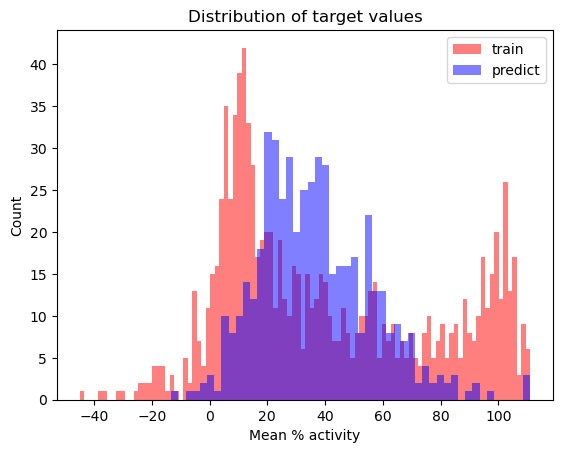

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(activity_trained, bins=100, alpha=0.5, color='r', label='train')
plt.hist(activity_predicted_rescaled, bins=50, alpha=0.5, color='b', label='predict')
plt.legend(loc='upper right')
plt.title('Distribution of target values')
plt.xlabel('Mean % activity')
plt.ylabel('Count')
plt.show()

Save for submission

In [40]:
pd.DataFrame(activity_predicted_rescaled, columns=["prediction"]).to_csv(f'{base_out_dir}/tox24_challenge_test_predicted.csv')